In [1]:
from IPython.core.display import HTML
HTML("""
<style>

div.text_cell_render { /* Customize text cells */

font-size:1.1em;
line-height:1.4em;

}
</style>
""")

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import dlib
import os, pickle

## Steps

1. Detect face using Dlib frontal face detector
- Align, i.e. rotate and scale the face to 160x160
- Run FaceNet on the resulting face to get a 128-d embedding
- Use PCA and LDA to demontrate resulting clusters.

In [3]:
downloads_path = os.path.expanduser('~/Downloads')

## Face detection

In [4]:
from align.align_dlib import AlignDlib
align = AlignDlib('models/dlib/shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()

def detect_face_dlib(path):
    image = mpimg.imread(path)
    bbs = detector(image, 1)
    tuples = []
    for r in bbs:
        tuples.append((r.left(), r.top(), r.right(), r.bottom()))
    return tuples, image

In [5]:
_face_cascade = cv2.CascadeClassifier('cascades/haarcascade_frontalface_default.xml')

def detect_face_haar(path):
    image = mpimg.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    bbs = _face_cascade.detectMultiScale(image, scaleFactor=1.25, 
                                 minNeighbors=3, 
                                 minSize=(20, 20), 
                                 flags = cv2.CASCADE_SCALE_IMAGE)
    tuples = [tuple(rect) for rect in bbs]
    return tuples, image

In [6]:
EXPECT_SIZE = 160

def align_face(image, face_box):
    landmarks = align.findLandmarks(image, face_box)
    alignedFace = align.align(EXPECT_SIZE, image, face_box, 
                              landmarks=landmarks,
                              landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    return alignedFace

In [7]:
import os

def box_all_faces(face_detect_proc, outdir):
    dir = downloads_path + '/lfw'

    if outdir:
        os.makedirs(outdir, exist_ok=True)

    for person_name in os.listdir(dir):
        person_dir = dir + '/' + person_name
        if os.path.isdir(person_dir):
            for fname in os.listdir(person_dir):
                image_path = person_dir + '/' + fname
                rects, image = face_detect_proc(image_path)
                for left, top, right, bottom in rects:
                    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
                if outdir:
                    cv2.imwrite(outdir + '/' + fname, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

Detect faces and write them to a separate directory. Time it. We'll compare the speed of Haar cascades and Dlib face detection.

### Haar Cascade

In [8]:
# %time box_all_faces(detect_face_haar, None)

### Dlib face detector

In [9]:
# %time box_all_faces(detect_face_dlib, downloads_path + '/lfw_dlib')

## FaceNet application

In [10]:
from os import path

def load_model(model_meta, model_content):
    s = tf.InteractiveSession()
    saver = tf.train.import_meta_graph(model_meta)
    saver.restore(s, model_content)
    tf.get_default_graph().as_graph_def()
    return s

In [12]:
session = load_model('models/20170216-091149/model-20170216-091149.meta', 
                     'models/20170216-091149/model-20170216-091149.ckpt-250000')

In [13]:
graph = tf.get_default_graph()
image_batch = graph.get_tensor_by_name("input:0")
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
embeddings = graph.get_tensor_by_name("embeddings:0")

In [14]:
def rep_for_image_path(session, image_path):
    global image_batch, phase_train_placeholder, embeddings
    
    tuples, face_orig = detect_face(image_path)
    if len(rects) > 0:
        face = align_face(face_orig, rects[0])
        feed_dict = { 
            image_batch: np.expand_dims(face, 0), 
            phase_train_placeholder: False }
    
        rep = session.run(embeddings, feed_dict=feed_dict)
    else:
        rep = None
    return rep

In [15]:
def reps_for_person(dir_name):
    all = []
    file_names = []

    for fname in os.listdir(dir_name):
        rep = rep_for_image_path(session, dir_name + '/' + fname)
        if rep is not None:
            all.append(rep[0])
            file_names.append(fname)
    return np.array(all), file_names

def load_people_faces(dir_path, person_paths):
    assert isinstance(person_paths, list)
    result = []
    all_file_names = []
    for person_path in person_paths:
        full_path = dir_path + '/' + person_path
        reps, file_names = reps_for_person(full_path)
        result.append(reps)
        all_file_names.append(file_names)
    return np.array(result), all_file_names

## Display 

In [16]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

def face_pca(rep, classes):
    n_components = 2
    rep_normalized = rep
    pca = LinearDiscriminantAnalysis(solver='eigen', n_components=n_components)
    result = pca.fit(rep_normalized, classes).transform(rep_normalized)
    print ('explained variance (first %d components): %.2f'%(n_components, sum(pca.explained_variance_ratio_)))
    return result

In [17]:
def split_matrix_to_people_list(people, people_matrix):
    prev = 0
    pca_list = []
    for p in people:
        pca_result = people_matrix[prev:prev+p.shape[0]]
        pca_list.append(pca_result)
        prev = p.shape[0]
    return pca_list

def compress_to_2d(people):
    all, classes = people_to_classes(people)
    pca_combined = face_pca(all, classes)
    return split_matrix_to_people_list(people, pca_combined)

def people_to_classes(people):
    all = np.concatenate(tuple(people))
    classes = []
    prev = 0
    for class_id, p in enumerate(people):
        length = p.shape[0]
        this_class = np.empty(length).astype(np.int)
        this_class[:] = int(class_id)
        classes.extend(this_class)
    return all, np.array(classes)

## LDA

In [ ]:
people, _ = load_people_faces(downloads_path + '/lfw', 
                           ['Bill_Gates', 
                            'Britney_Spears', 
                           ])

In [ ]:
X, classes = people_to_classes(people)
classes

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen', shrinkage='auto')
p = PCA(n_components=2)
people_lda = lda.fit(X, classes).transform(X)
people_pca = pca.fit(X).transform(X)
print(X.shape, classes.shape, people_pca.shape)

Use of LDA requies both `solver='eigen'` and `shrinkage='auto'`. Need to investigate why.

In [21]:
def draw_pca_result(people, people_pca, names):
    people_2d = split_matrix_to_people_list(people, people_pca)
    colors = cm.rainbow(np.linspace(0, 1, len(people_2d)))
   
    plt.figure(dpi=150)
    plt.xticks([])
    plt.yticks([])
    plots = []
    for p, color in zip(people_2d, colors):
        x, y = tuple(np.split(p, 2, axis=1))
        plots.append(plt.scatter(x, y, color=color))
    
#     plt.legend(plots, names, loc='best', shadow=False, scatterpoints=1)

We cannot blindly apply PCA. It will pick dimensions with max total variance. However, the variance of one person may dominate. We may not see a clean separation. We need to choose the projection that best separates different people.

How to do it. Consolidate each person to a single vector: center of mass. Project the resulting two vectors. Use that projection to depict the original vectors.

SOLUTION: use Linear Discriminant Analysis.

## Full pipeline

In [18]:
import matplotlib.cm as cm

def main():
    people = load_people_faces(downloads_path + '/lfw-deepfunneled', ['Bill_Gates', 'Serena_Williams'])
    lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen', shrinkage='auto')
    people_lda = lda.fit(X, classes).transform(X)
#     p = PCA(n_components=2)
#     people_pca = pca.fit(X).transform(X)
    print(X.shape, classes.shape, people_pca.shape)
    draw_pca_result(people, people_lda)

In [19]:
import matplotlib.cm as cm

def load_people_from_dict(people_names):
    with open(downloads_path + '/lfw/face_vecs-lfw.pickle', 'rb') as f:
        faces_dict = pickle.load(f)
    vecs = []
    names = []
    for name in people_names:
        vecs.append(faces_dict[name]['reps'])
        names.append(faces_dict[name]['names'])
    return np.array(vecs), names

def cluster_lfw(names, cluster_with=LinearDiscriminantAnalysis(n_components=2, solver='eigen', shrinkage='auto')):
    people, _ = load_people_from_dict(names)
    X, classes = people_to_classes(people)
    people_lda = cluster_with\
        .fit(X, classes)\
        .transform(X)
    draw_pca_result(people, people_lda, names)

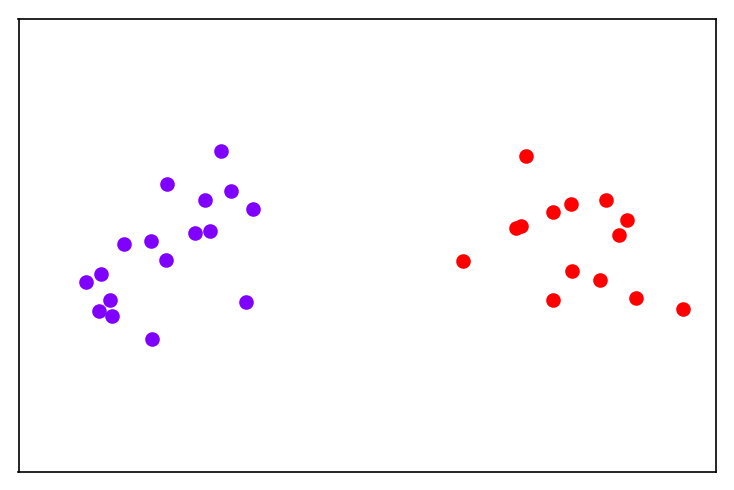

In [22]:
cluster_lfw(['Bill_Gates', 'Britney_Spears'])

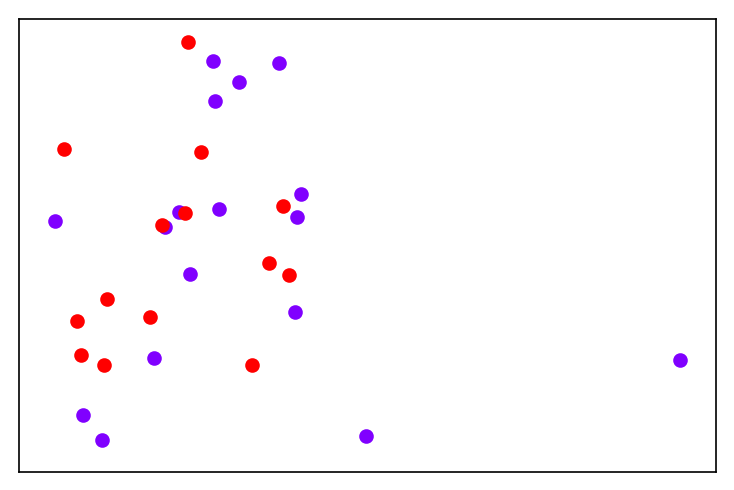

In [23]:
cluster_lfw(['Bill_Gates', 'Britney_Spears'], PCA(n_components=2))

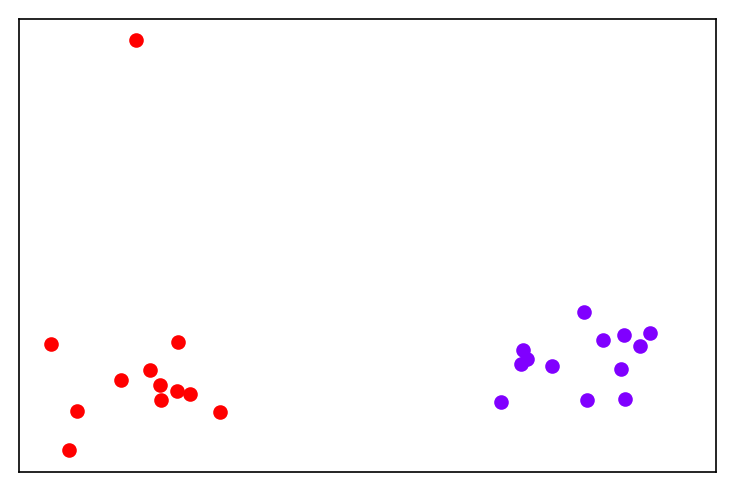

In [24]:
cluster_lfw(['Queen_Elizabeth_II', 'Harrison_Ford'])

## PCA va LDA for Iris dataset

In [ ]:
print(__doc__)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target

y

In [ ]:
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

X

In [ ]:

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()


# Embeddings for all faces in LFW

In [ ]:
from ipywidgets import FloatProgress
from IPython.display import display

def load_all_faces(root_dir, pickle_file_name):
    reps_per_person = {}

    pickle_path = root_dir + '/' + pickle_file_name
    if os.path.isfile(pickle_path):
        with open(pickle_path, 'rb') as f:
            reps_per_person = pickle.load(f)
            assert isinstance(reps_per_person, dict)
    
    person_dirs = os.listdir(root_dir)
    progress = FloatProgress(min=0, max=len(person_dirs))
    display(progress)
    
    for person_dir in person_dirs:
        progress.value += 1
#         print(person_dir, os.path.isdir(person_dir))
        person_dir_path = root_dir + '/' + person_dir
        if os.path.isdir(person_dir_path):
            if person_dir not in reps_per_person:
                person_face_vecs, all_file_names = load_people_faces(root_dir, [person_dir])
                reps = person_face_vecs[0]
                file_names = all_file_names[0]
    #             print(reps.shape, len(file_names))
                assert reps.shape[0] == len(file_names)
                reps_per_person[person_dir] = {
                    'reps': reps,
                    'names': file_names
                }
                with open(pickle_path, 'wb') as f:
                    pickle.dump(reps_per_person, f, 2)       

In [ ]:
%time load_all_faces(downloads_path + '/lfw', 'face_vecs-lfw.pickle')

In [ ]:
vecs, names = load_people_from_dict(['Bill_Gates'])

In [ ]:
vec = vecs[0][names[0].index('Bill_Gates_0015.jpg')]
vec = np.round(vec * 100) / 100.
vec